In [108]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd

In [109]:
tckrs = ["ADBE", "AMAT", "AMZN", "BRK-B", "DAL", "GOOG", "MCD"]

In [110]:
start = "2020-01-18"
end = "2021-11-01"
lookahead = 5

In [111]:
dates = pd.date_range(start, end)

In [112]:
base = "/home/greg_b/voltron/experiments/trading/saved-outputs/"

In [113]:
full_predictions = []
has_dates = []
for date in dates:
    cap = str(date)[:10]
    try:
        predictions = torch.stack([torch.load(base + tckr + "/volt_ewma200_"+cap+".pt") for tckr in tckrs])
        full_predictions.append(predictions)
        has_dates.append(cap)
    except:
        pass
        # print(cap)

In [114]:
daily_predictions = torch.stack(full_predictions)

In [115]:
daily_predictions.shape

torch.Size([451, 7, 1000, 20])

In [116]:
from pandas.tseries.holiday import USFederalHolidayCalendar


In [117]:
date

Timestamp('2021-11-01 00:00:00', freq='D')

In [118]:
bday_us = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [119]:
end_plus_20 = str(pd.date_range(start=end, periods=21, freq=bday_us)[-1])[:10]

In [120]:
observations = torch.tensor(
    [yf.download(tckr, start=start, end=end_plus_20).Close.values for tckr in tckrs]
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [121]:
idcs = torch.arange(0, daily_predictions.shape[0] - lookahead, lookahead)

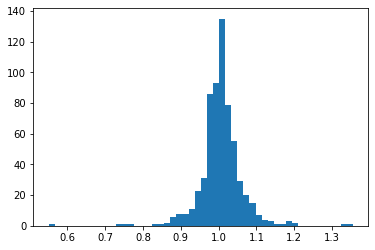

In [122]:
returns = (observations[..., idcs+lookahead] / observations[..., idcs])
plt.hist(returns.flatten().numpy(), bins=50);

In [123]:
# returns = ((observations[..., idcs+lookahead] - observations[..., idcs]) / observations[..., idcs])
# plt.hist(returns.flatten().numpy(), bins=50);

In [124]:
daily_predictions.shape

torch.Size([451, 7, 1000, 20])

In [125]:
num_obs = daily_predictions.shape[0]

In [126]:
tenday_lookahead = daily_predictions[..., lookahead].permute(1, 2, 0)

In [127]:
exp_means = tenday_lookahead.exp().mean(1)
exp_stds = tenday_lookahead.exp().std(1)

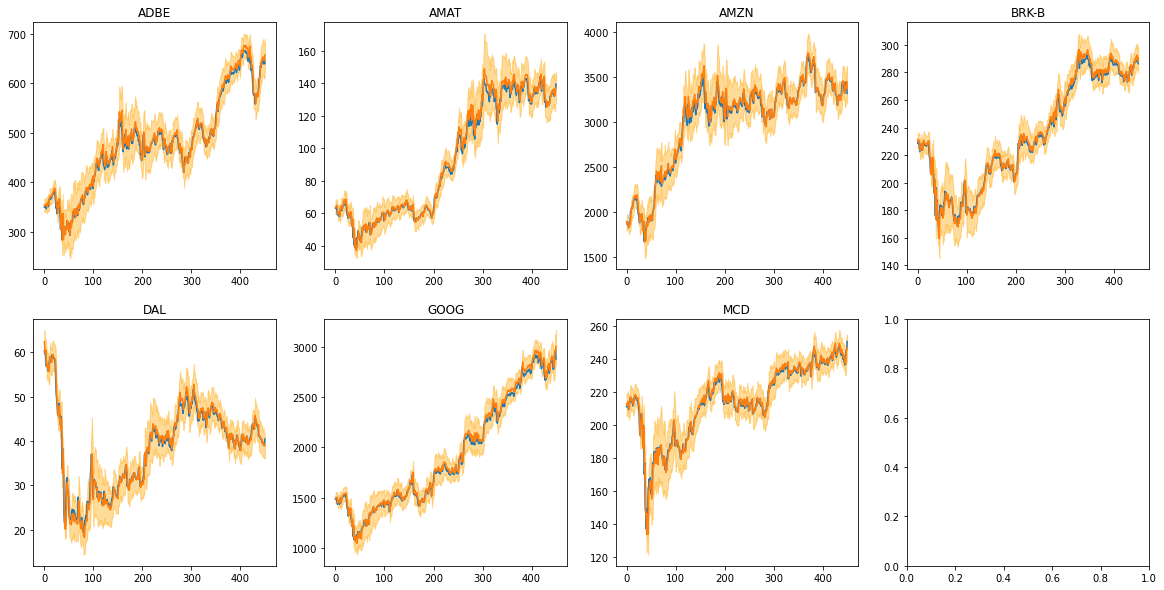

In [128]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
ax = ax.reshape(-1)

for i in range(7):
    # ax[i].plot(torch.arange(-lookahead, -lookahead+num_obs+22), observations[i])
    ax[i].plot(observations[i, :-20])
    ax[i].plot(exp_means[i])
    ax[i].fill_between(
        torch.arange(num_obs), 
        (exp_means - 2 * exp_stds)[i],
        (exp_means + 2 * exp_stds)[i],
        alpha = 0.4, 
        color = "orange"
    )
    ax[i].set_title(tckrs[i])

In [129]:
returns_for_cov = (observations[..., lookahead:] - observations[..., :-lookahead]) \
    / observations[..., :-lookahead]

In [130]:
returns_for_cov.shape

torch.Size([7, 466])

In [131]:
lookahead_price = tenday_lookahead.exp()

In [132]:
lookahead_price.shape

torch.Size([7, 1000, 451])

In [133]:
returns_from_preds = (lookahead_price[..., lookahead:] - lookahead_price[..., :-lookahead]) \
    / lookahead_price[..., :-lookahead]

In [134]:
lookahead_price[..., lookahead:].shape

torch.Size([7, 1000, 446])

In [135]:
returns_from_obs = (lookahead_price[..., lookahead:] - observations[..., :-(lookahead+20)].unsqueeze(-2)) \
    / observations[..., :-(lookahead+20)].unsqueeze(-2)

In [136]:
returns_from_preds.shape

torch.Size([7, 1000, 446])

Text(0.5, 0.98, 'Predicted vs Actual Returns')

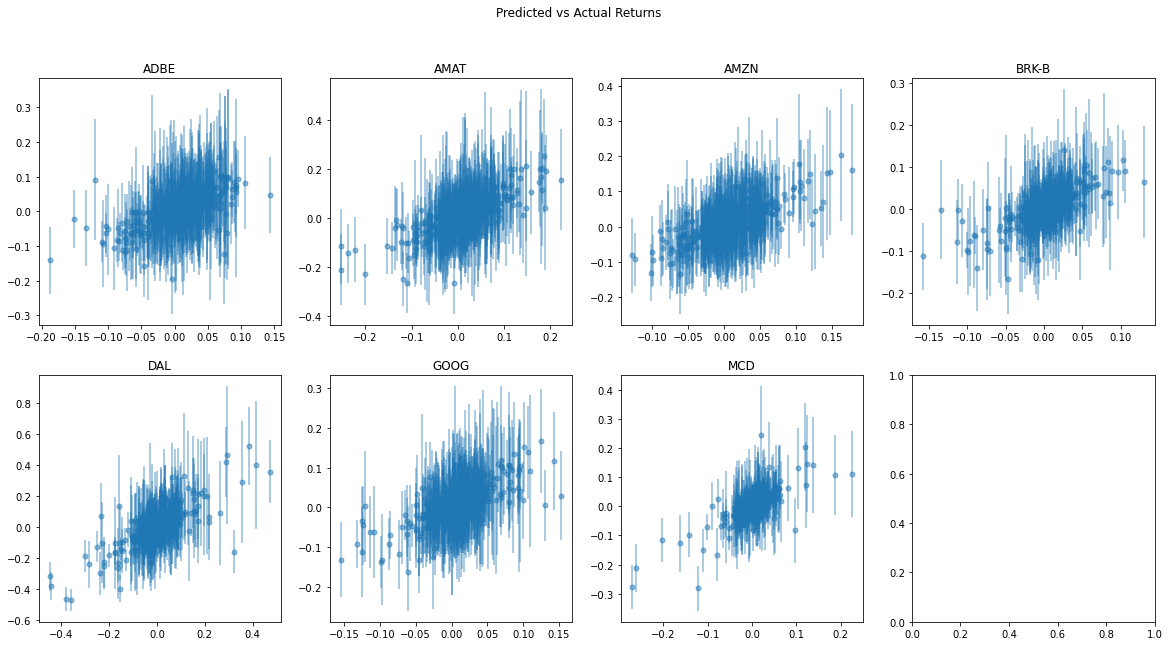

In [137]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
ax = ax.reshape(-1)

for i in range(7):
    # ax[i].plot(torch.arange(-lookahead, -lookahead+num_obs+22), observations[i])
    ax[i].errorbar(returns_for_cov[i, :-20], returns_from_preds[i].mean(0), 
                   yerr=returns_from_preds[i].std(0) * 2., ls = "none",
                  marker = ".", markersize = 10, alpha = 0.5)
    ax[i].set_title(tckrs[i])
fig.suptitle("Predicted vs Actual Returns")

Text(0.5, 0.98, 'Observed vs Actual Returns')

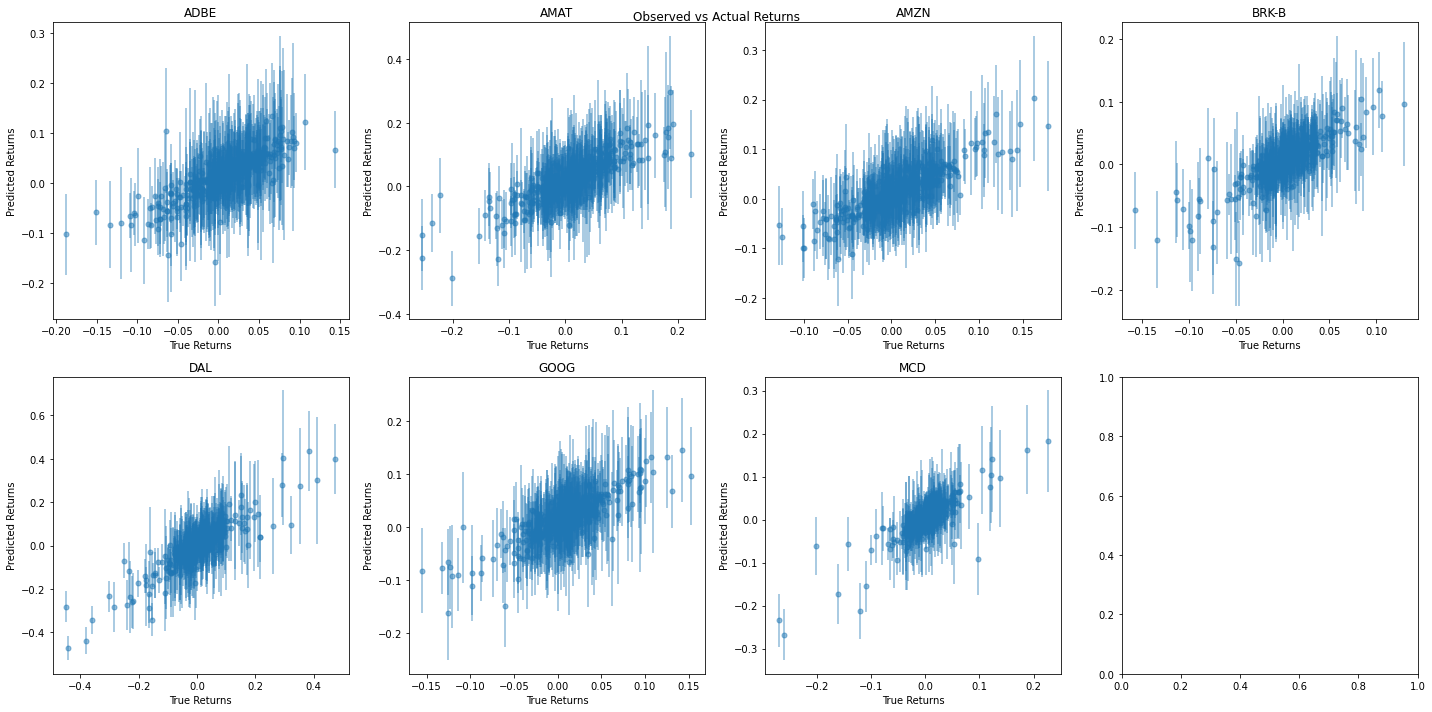

In [138]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
ax = ax.reshape(-1)

for i in range(7):
    # ax[i].plot(torch.arange(-lookahead, -lookahead+num_obs+22), observations[i])
    ax[i].errorbar(returns_for_cov[i, :-20], returns_from_obs[i].mean(0), 
                   yerr=returns_from_obs[i].std(0) * 2., ls = "none",
                  marker = ".", markersize = 10, alpha = 0.5)
    ax[i].set_title(tckrs[i])
    ax[i].set_xlabel("True Returns")
    ax[i].set_ylabel("Predicted Returns")
plt.tight_layout()
fig.suptitle("Observed vs Actual Returns")

In [139]:
excess_returns = returns_from_obs - lookahead / 252 * 0.03

In [140]:
mean_excess_returns = excess_returns.mean(1)

In [141]:
cov_excess_returns = torch.stack([torch.cov(excess_returns[..., i]) for i in range(excess_returns.shape[-1])])

In [142]:
opt_excess_returns = returns_for_cov - lookahead / 252 * 0.03
cov_opt_excess_returns = torch.stack(
    [torch.cov(opt_excess_returns[..., :i]) for i in range(opt_excess_returns.shape[-1])]
)

<ipython-input-142-73c7889cd943>:3: UserWarning: cov(): degrees of freedom is <= 0 (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/aten/src/ATen/native/Correlation.cpp:99.)
  [torch.cov(opt_excess_returns[..., :i]) for i in range(opt_excess_returns.shape[-1])]


In [143]:
cov_opt_excess_returns[0:2] = cov_opt_excess_returns[2]

In [157]:
def compute_strategy(excess_returns, cov_est=None, normalize = False):
    if cov_est is None:
        batched_covs = torch.stack([torch.cov(excess_returns[..., i]) for i in range(excess_returns.shape[-1])])
    else:
        batched_covs = cov_est
    # expected_returns = excess_returns.mean(1)
    
    weights = torch.solve(excess_returns.t().unsqueeze(-1), batched_covs)[0]
    norm_constant = excess_returns.t().unsqueeze(-2).matmul(weights).sum(-1)
    res = weights.squeeze(-1) / norm_constant
    if normalize:
        res = res / res.abs().sum(1,keepdim=True)
        
    return res
    

In [158]:
weights = compute_strategy(mean_excess_returns, cov_opt_excess_returns[:-20], normalize=False) / (252 / 5)

In [168]:
weights = 1./7. * torch.ones_like(weights)

In [169]:
opt_weights = compute_strategy(opt_excess_returns, cov_opt_excess_returns, normalize=False) / (252 / 5)

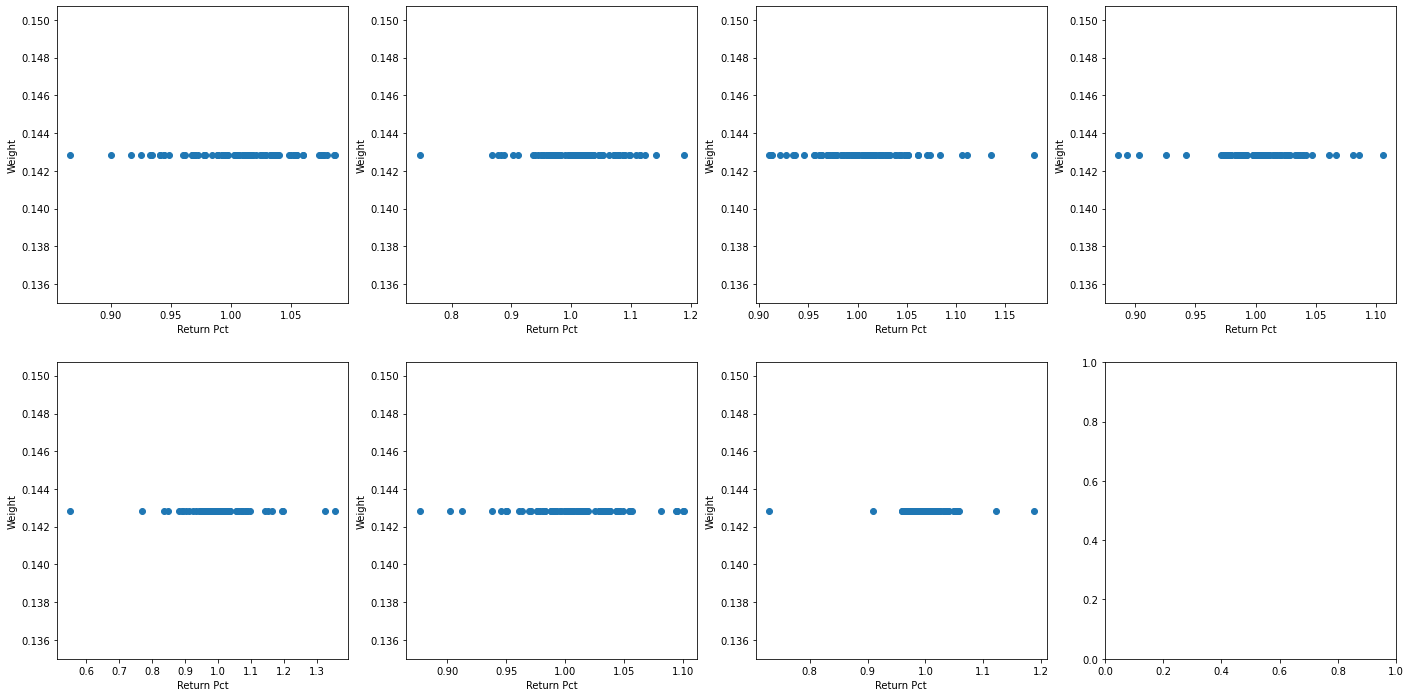

In [170]:
fig, ax = plt.subplots(2, 4, figsize = (24, 12))
ax = ax.reshape(-1)

for i in range(7):
    ax[i].scatter(returns[i, :], weights[idcs, i], label = "Volt")
    # ax[i].scatter(returns_for_cov[i, :-20], opt_weights[:-20, i])
    ax[i].set_xlabel("Return Pct")
    ax[i].set_ylabel("Weight")

In [171]:
5/252 * 0.03

0.0005952380952380952

In [178]:
renorm_pos_weights = weights
abs_pos_weights = weights.clamp(min=0.).sum(1)
renorm_pos_weights[abs_pos_weights > 1] /= abs_pos_weights[abs_pos_weights > 1].unsqueeze(-1)

In [179]:
renorm_cum_returns = (1 + (renorm_pos_weights[idcs] * (returns.t() - 1)).sum(1))#.cumprod(0)
weights_cum_returns = ((returns.t() - (weights[idcs] < 0) * 2.) * weights[idcs])#.cumprod(0)

In [180]:
(returns.t() * renorm_pos_weights[idcs]).sum(1).add(-5/252).cumprod(0)

tensor([0.9591, 0.9696, 0.9711, 0.9671, 0.8641, 0.8485, 0.7364, 0.5907, 0.6443,
        0.6020, 0.6407, 0.6549, 0.6370, 0.6527, 0.6184, 0.5952, 0.6190, 0.6248,
        0.6665, 0.6280, 0.6284, 0.5946, 0.6278, 0.6068, 0.6103, 0.5906, 0.5814,
        0.5949, 0.5848, 0.5902, 0.5938, 0.5572, 0.5612, 0.5329, 0.5260, 0.5160,
        0.5341, 0.5116, 0.4935, 0.4790, 0.5007, 0.5055, 0.5110, 0.5059, 0.4946,
        0.4868, 0.4709, 0.4692, 0.4663, 0.4523, 0.4578, 0.4406, 0.4565, 0.4611,
        0.4476, 0.4375, 0.4237, 0.4246, 0.4120, 0.4150, 0.4309, 0.4212, 0.4135,
        0.4110, 0.3947, 0.3693, 0.3754, 0.3818, 0.3699, 0.3721, 0.3654, 0.3605,
        0.3531, 0.3514, 0.3370, 0.3412, 0.3287, 0.3251, 0.3151, 0.3049, 0.3107,
        0.3047, 0.2978, 0.2873, 0.2881, 0.2688, 0.2674, 0.2682, 0.2614, 0.2606],
       dtype=torch.float64)

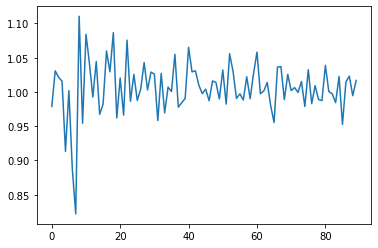

In [181]:
plt.plot(renorm_cum_returns)

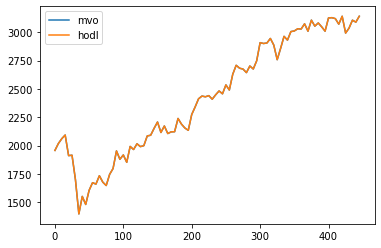

In [188]:
plt.plot(idcs, 2000 * renorm_cum_returns.cumprod(0), label = "mvo")
# plt.plot(idcs, 2000 * weights_cum_returns.cumprod(0),
#         label = "volt w/ shorts")
plt.plot(idcs, returns.mean(0).cumprod(0) * 2000, label = "hodl")
plt.legend()


Text(0.5, 1.0, 'renorm mvo')

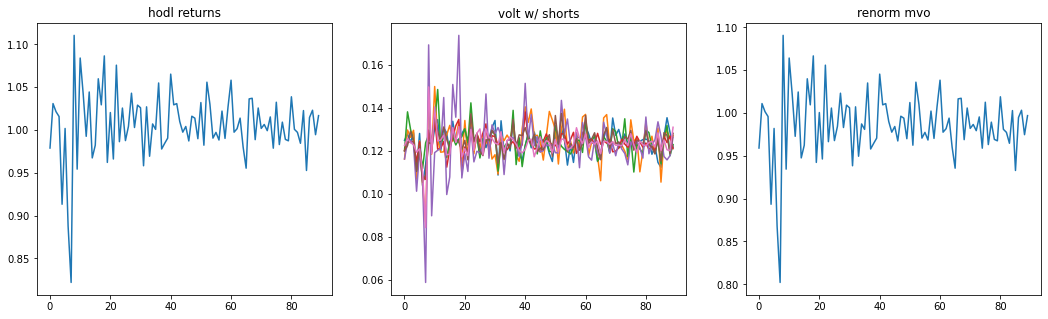

In [183]:
fig, ax = plt.subplots(1, 3, figsize = (18, 5))#, sharey=True)
ax[0].plot(returns.mean(0))
ax[0].set_title("hodl returns")

ax[1].plot(weights_cum_returns - 5/252)
ax[1].set_title("volt w/ shorts")

ax[2].plot(renorm_cum_returns - 5/252)
ax[2].set_title("renorm mvo")

# ax[1].set_ylim((0.9, 1.1))

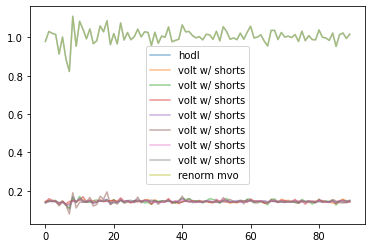

In [184]:
plt.plot(returns.mean(0), label = "hodl", alpha = 0.5)
plt.plot(weights_cum_returns, label = "volt w/ shorts", alpha = 0.5)
plt.plot(renorm_cum_returns, label = "renorm mvo", alpha = 0.5)
# plt.ylim((0.95, 1.1))
plt.legend()

In [185]:
((returns.t() + 2. * weights[idcs].clamp(min=0.).sign()) * weights[idcs].abs()).sum(1)#.cumprod(0)

tensor([2.9789, 3.0308, 3.0214, 3.0157, 2.9133, 3.0018, 2.8878, 2.8220, 3.1105,
        2.9543, 3.0840, 3.0420, 2.9926, 3.0444, 2.9674, 2.9822, 3.0598, 3.0294,
        3.0865, 2.9621, 3.0204, 2.9661, 3.0757, 2.9864, 3.0256, 2.9876, 3.0043,
        3.0429, 3.0029, 3.0290, 3.0259, 2.9582, 3.0270, 2.9694, 3.0071, 3.0007,
        3.0549, 2.9778, 2.9844, 2.9905, 3.0652, 3.0294, 3.0308, 3.0099, 2.9975,
        3.0041, 2.9872, 3.0161, 3.0138, 2.9898, 3.0320, 2.9822, 3.0558, 3.0300,
        2.9905, 2.9972, 2.9883, 3.0221, 2.9902, 3.0271, 3.0581, 2.9974, 3.0015,
        3.0138, 2.9801, 2.9554, 3.0363, 3.0370, 2.9887, 3.0257, 3.0018, 3.0064,
        2.9992, 3.0152, 2.9788, 3.0324, 2.9830, 3.0092, 2.9890, 2.9874, 3.0388,
        3.0008, 2.9972, 2.9845, 3.0227, 2.9527, 3.0146, 3.0231, 2.9945, 3.0168],
       dtype=torch.float64)

In [91]:
compute_pct_returns = lambda w: ((w * returns_for_cov[..., :-20]).sum(0)).cumsum(0)

In [92]:
nw = torch.ones_like(weights) / 7

In [93]:
nw.shape

torch.Size([446, 7])

In [94]:
raw_returns = (observations[..., lookahead:] - observations[..., :-lookahead])

In [95]:
value_at_time_curr = observations[..., :-lookahead].t()
value_at_time_next = observations[..., lookahead:].t()

In [96]:
valuation = torch.zeros(nw.shape[0]+1)
valuation[0] = 2000

for i in range(1, 5):
    cash_proportion = nw[i-1] * valuation[i-1]
    num_stocks = cash_proportion / value_at_time_curr[i]
    new_valuation = num_stocks * value_at_time_next[i]
    print(new_valuation)
    valuation[i] = new_valuation.sum()

tensor([287.0202, 267.5134, 281.2548, 279.4409, 271.3903, 280.4613, 289.7681],
       dtype=torch.float64)
tensor([283.5075, 263.6231, 277.4880, 277.7218, 264.8464, 273.7563, 283.1650],
       dtype=torch.float64)
tensor([274.6927, 257.0946, 296.5891, 271.9283, 260.5237, 268.7856, 278.4250],
       dtype=torch.float64)
tensor([281.2988, 275.6697, 298.7950, 273.8268, 268.7878, 282.4695, 280.1811],
       dtype=torch.float64)


In [97]:
valuation[0]

tensor(2000.)

In [98]:
nw[0] * valuation[0] / value_at_time_curr[0] * value_at_time_next[0]

tensor([289.4939, 272.1067, 279.8626, 279.9658, 272.1720, 279.5858, 284.6724],
       dtype=torch.float64)

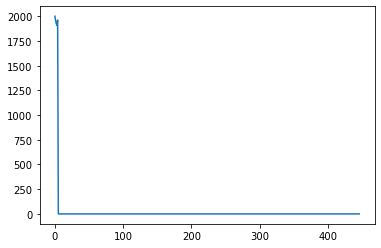

In [99]:
plt.plot(valuation)

In [100]:
weights.clamp(min=0.).sum(0)

tensor([45.0888, 23.9397, 21.2958, 32.6268,  7.7513, 35.6730, 21.7235],
       dtype=torch.float64)

In [101]:
weights.clamp(min=0.) / weights.clamp(min=0.).sum(1,keepdim=True)

tensor([[0.0000, 0.3637, 0.2998,  ..., 0.2354, 0.1011, 0.0000],
        [0.0000, 0.2210, 0.1858,  ..., 0.4708, 0.1224, 0.0000],
        [0.0762, 0.4574, 0.4664,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0876, 0.0000, 0.0000,  ..., 0.0000, 0.6901, 0.1407],
        [0.0000, 0.0000, 0.0696,  ..., 0.0000, 0.6920, 0.2385],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7403, 0.2597]],
       dtype=torch.float64)

In [102]:
weights.shape

torch.Size([446, 7])

In [103]:
idcs = torch.arange(0, weights.shape[0], 5)

In [104]:
idcs

tensor([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
         70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135,
        140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205,
        210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275,
        280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345,
        350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415,
        420, 425, 430, 435, 440, 445])

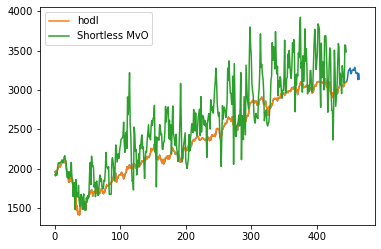

In [105]:
plt.plot((2000 / 7 / value_at_time_curr[0] * value_at_time_next).sum(1))
plt.plot((2000 * nw / value_at_time_curr[0] * value_at_time_next[:-20]).sum(1), label = "hodl")
plt.plot((2000 * weights.clamp(min=0.) / weights.clamp(min=0.).sum(1,keepdim=True) / \
          value_at_time_curr[0] * value_at_time_next[:-20]).sum(1), label = "Shortless MvO")
plt.legend()

In [106]:
nw.shape

torch.Size([446, 7])

In [97]:
value_mvo = (2000 * weights.clamp(min=0.) / weights.clamp(min=0.).sum(1,keepdim=True) / \
          value_at_time_curr[0] * value_at_time_next[:-20]).sum(1)

In [98]:
value_mvo[100:110]

tensor([2366.5299, 2323.2260, 2445.3728, 2463.2972, 2464.5993, 2494.4806,
        2600.8340, 2664.3831, 2552.9463, 2466.9879], dtype=torch.float64)

In [117]:
norm_pos_weights = weights.clamp(min=0.) / weights.clamp(min=0.).sum(1,keepdim=True)
norm_pos_weights = norm_pos_weights[idcs]

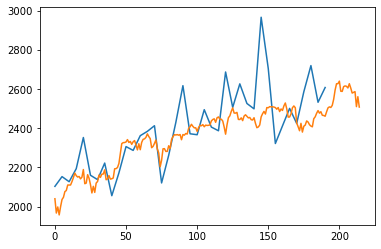

In [125]:
plt.plot(idcs, 2000 * (norm_pos_weights * value_at_time_next[idcs] / value_at_time_curr[0]).sum(1))
plt.plot((2000 / 7 / value_at_time_curr[0] * value_at_time_next).sum(1))

Text(0.5, 1.0, 'returns')

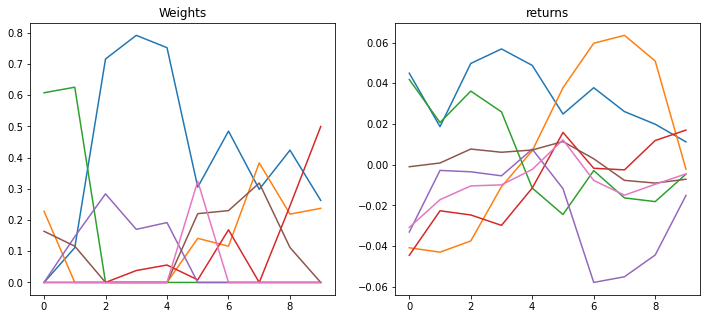

In [112]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(norm_pos_weights[100:110])
ax[1].plot(returns_for_cov[:, 100:110].t())
ax[0].set_title("Weights")
ax[1].set_title("returns")

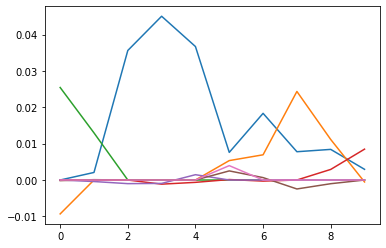

In [113]:
plt.plot(norm_pos_weights[100:110] * returns_for_cov[:, 100:110].t())